In [2]:
import pickle
#dm_rain_model={'pca_dm_rain':pca_dm_rain,'dm_rain_mean':dm_rain_mean,'dm_rain_std':dm_rain_std}
#with open('dm_rain_model.pkl','wb') as f:
#    pickle.dump(dm_rain_model,f)
with open('dm_rain_model.pkl','rb') as f:
    dm_rain_model=pickle.load(f)
pca_dm_rain=dm_rain_model['pca_dm_rain']
dm_rain_mean=dm_rain_model['dm_rain_mean']
dm_rain_std=dm_rain_model['dm_rain_std']


In [7]:
#print(dir(pca_dm_rain))
print(pca_dm_rain.singular_values_)
import numpy as np
print(pca_dm_rain.whiten)

[969.969   540.77423 381.8089  206.01193]
False


In [20]:
scaling_factors = 1.0 / np.sqrt(pca_dm_rain.singular_values_)
from sklearn.decomposition import PCA

n_components = pca_dm_rain.n_components_  # Get the number of components
random_variables = np.random.normal(size=(100,n_components))

# Scale the random variables
scaled_random_variables = 2*random_variables #* scaling_factors

# Reconstruct data
scaled_data = pca_dm_rain.inverse_transform(scaled_random_variables)
natural_data = scaled_data * dm_rain_std + dm_rain_mean
dm=natural_data[:,0:15]
rainRate=np.exp(natural_data[:,15:])-1
#

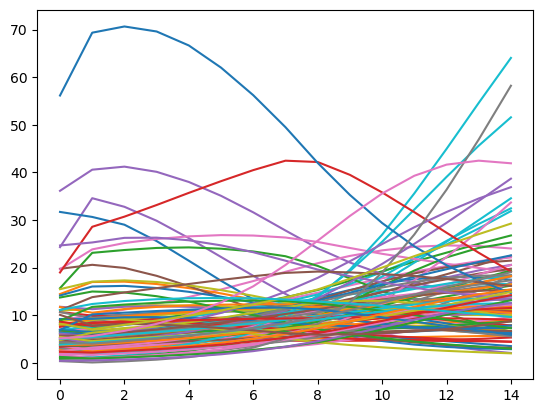

In [21]:
import matplotlib.pyplot as plt
#plt.plot(dm.T)
plt.plot(rainRate.T)

8.0


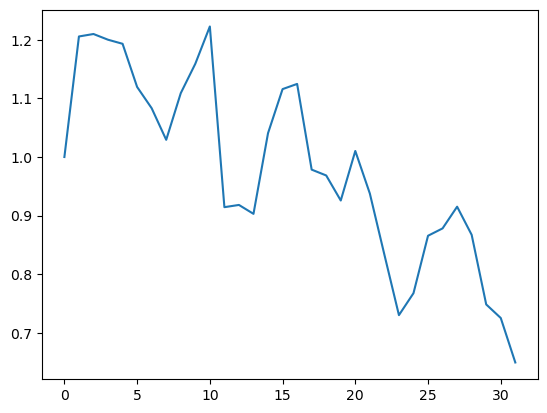

In [24]:
import numpy as np
import matplotlib.pyplot as plt
def ou_process(x0, mu, sigma, dt, tau):
    x = np.zeros_like(x0)
    x[0] = mu
    for t in range(1, len(x0)):
        x[t] = x[t-1] + dt * (mu - x[t-1]) / tau + sigma * np.sqrt(dt) * np.random.normal()
    return x

mu=1.0
sigma=0.1
dt=1
tau=10
x=ou_process(np.zeros(32),mu,sigma,dt,tau)
plt.plot(x)
print(64*0.125)


In [104]:
nt=5000
x=np.random.normal(0,1,nt)
rx=np.random.rand(nt)
sfcRainRate=1.5*(np.exp(2+1.0*x))
flRainRate=(1+rx)*(np.exp(2+1.0*x))
print(sfcRainRate.mean())
print(sfcRainRate.max())
print(sfcRainRate.min())
a=np.nonzero(sfcRainRate>15)
print(len(a[0]))
rainRate1DL=[]
def ou_process1d(x0, mu, sigma, dt, tau):
    x = np.zeros_like(x0)
    x[0] = mu[0]
    m_mu=np.mean(mu)
    for t in range(1, len(x0)):
        x[t] = x[t-1] + dt * (mu[t-1] - x[t-1]) / tau + sigma*m_mu * np.sqrt(dt) * np.random.normal()
        if x[t]<0.1:
            x[t]=0.1
    return x

def ou_process1d_dm(x0, mu, sigma, dt, tau):
    x = np.zeros_like(x0)
    x[0] = mu[0]
    m_mu=np.mean(mu)
    for t in range(1, len(x0)):
        x[t] = x[t-1] + dt * (mu[t-1] - x[t-1]) / tau + sigma*m_mu * np.sqrt(dt) * np.random.normal()
        if x[t]<0.5:
            x[t]=0.5
        if x[t]>3:
            x[t]=3
    return x
mu=1.0
sigma=1.0
dt=1
tau=10
for flRainRate1,sfcRainRate1 in zip(flRainRate,sfcRainRate):
    flRainRate1=min(flRainRate1,100)
    sfcRainRate1=min(sfcRainRate1,100)
    rainRate1D1=np.interp(range(0,32),[0,32],[flRainRate1,sfcRainRate1])
    rainRate1D1p=np.zeros_like(rainRate1D1)
    rainRate1D1p=ou_process1d(rainRate1D1p,rainRate1D1,0.125*sigma,dt,tau)
    rainRate1DL.append(rainRate1D1p)
#reconstructed_data = pca.inverse_transform(scaled_random_variables)])

17.966179805453734
343.99589387940733
0.3701533050520731
1857


1.6516328630014545


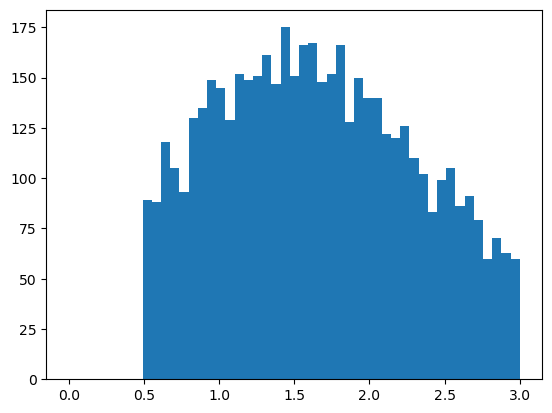

In [111]:
dm_top=[]
dm_sfc=[]
ic=0
while ic<nt:
    dm_ten=np.random.normal(0,1)+1.5
    if dm_ten>0.5 and dm_ten<3:
        dm_top.append(dm_ten)
        ic+=1
    dm_ten=np.random.normal(0,1)+1.5
    if dm_ten>0.5 and dm_ten<3:
        dm_sfc.append(dm_ten)

dm_top=np.array(dm_top)
dm_sfc=np.array(dm_sfc)
dm1DL=[]
for dm_top1,dm_sfc1 in zip(dm_top,dm_sfc):
    dm1D1=np.interp(range(0,32),[0,32],[dm_top1,dm_sfc1])
    dm1D1p=np.zeros_like(dm1D1)
    dm1D1p=ou_process1d_dm(dm1D1p,dm1D1,0.125*sigma,dt,tau)
    dm1DL.append(dm1D1p)

dm_sfc=np.exp(np.random.normal(0,1,nt))
print(dm_top.mean())
h1=plt.hist(dm_top,bins=np.linspace(0,3,50))

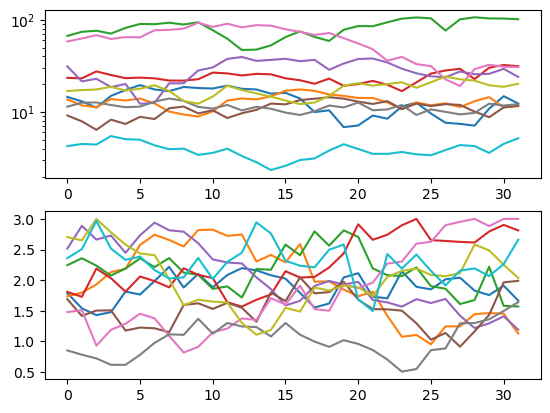

In [113]:
rainRate1DL=np.array(rainRate1DL)
dm1DL=np.array(dm1DL)
#plt.plot(np.mean(rainRate1DL,axis=0))
plt.subplot(2,1,1)
plt.plot(rainRate1DL[::500].T)
plt.yscale('log')
plt.subplot(2,1,2)
plt.plot(dm1DL[::500].T)
#plt.yscale('log')
#plt.plot(rainRate1DL[0])

In [123]:
from bisectm import bisectm
import lkTables as lkT
lkTables=lkT.scattTables()
dnwL=[]
dmL=[]
piaKuL=[]
dr=0.125
for dm1, rainRate1 in zip(dm1DL,rainRate1DL):
    piaKu1=0.0
    for k in range(32):
        ind=bisectm(lkTables.dmr.data, 289, dm1[k])
        dnw=np.log10(rainRate1[k]/lkTables.rainRate[ind])
        dnwL.append(dnw)
        dmL.append(dm1[k])
        piaKu1+=lkTables.attKuR[ind]*10**dnw*2*dr
    piaKuL.append(piaKu1)


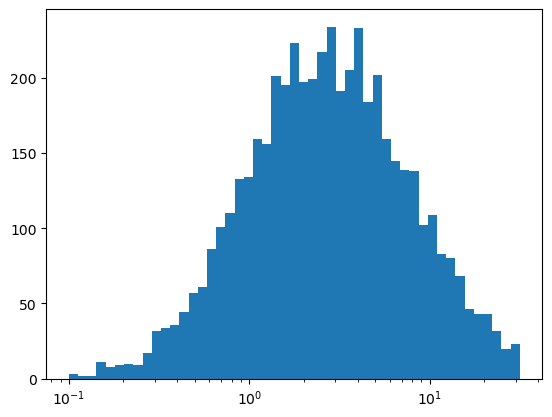

In [126]:
plt.hist(piaKuL,bins=np.logspace(-1,1.5,50))
plt.xscale('log')

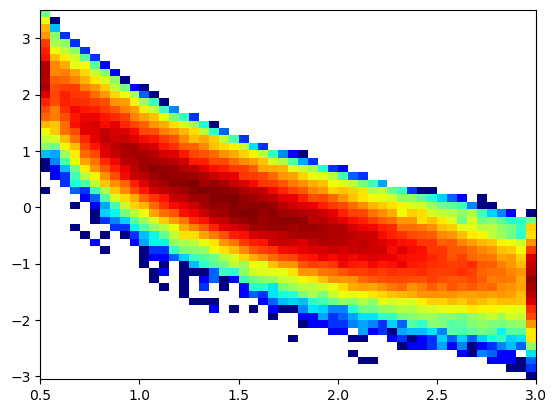

In [121]:
from matplotlib.colors import LogNorm
h1=plt.hist2d(dmL,dnwL,bins=50,cmap='jet',norm=LogNorm())

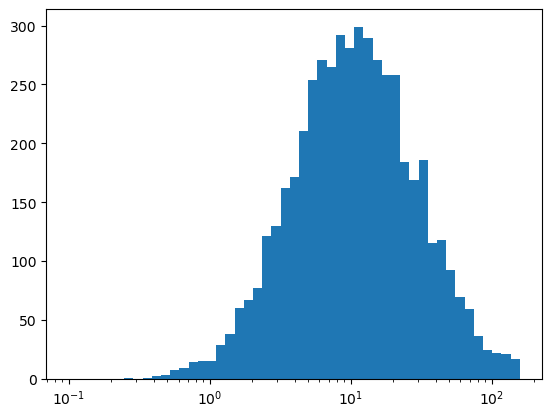

In [107]:
h1=plt.hist(flRainRate,bins=np.logspace(-1,2.2,50))
plt.gca().set_xscale("log")